In [1]:
from hig_data.coco import COCOStuffDataset

img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
dataset = COCOStuffDataset(img_path, mask_path, 32)


In [1]:
from hig_data.coco import COCOStuffDataset, CocoStuffGraphDataset
import torch
img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)
data = coco_graph[4]
data

tensor(64.)
tensor(87.)
tensor(166.)


RelaxedHeteroData(
  image=[1, 8, 32, 32],
  mask=[1, 1, 256, 256],
  image_node={
    x=[1024, 1],
    pos=[1024, 2],
  },
  class_node={
    x=[3, 183],
    pos=[3, 2],
  },
  (class_node, class_edge, class_node)={ edge_index=[2, 6] },
  (class_node, class_to_image, image_node)={ edge_index=[2, 971] }
)

In [10]:
from hig_data.coco import COCOStuffGraphPrecomputedDataset
import torch
path = '/Users/rupertmenneer/Downloads/coco_graph'
coco_graph = COCOStuffGraphPrecomputedDataset(path)
data = coco_graph[4]
data

Found 5000 complete datapoint in /Users/rupertmenneer/Downloads/coco_graph


RelaxedHeteroData(
  image=[1, 8, 32, 32],
  mask=[1, 1, 256, 256],
  image_node={
    x=[1024, 1],
    pos=[1024, 2],
  },
  class_node={
    x=[3, 183],
    pos=[3, 2],
  },
  (class_node, class_edge, class_node)={ edge_index=[2, 6] },
  (class_node, class_to_image, image_node)={ edge_index=[2, 1024] }
)

In [ ]:
coco_graph[10]

In [9]:
from hig_data.coco import CocoStuffGraphDataset
import numpy as np
import os
def create_graph_dataset_and_export(output_dir='/Users/rupertmenneer/Downloads/coco_graph'):

    img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
    mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
    coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)

    for idx in range(len(coco_graph)):
        image, mask = coco_graph.dataset[idx]
        graph = coco_graph[idx]

        name = coco_graph.dataset._fnames['image'][coco_graph.dataset._raw_idx[idx]]
        raw_id = os.path.splitext(os.path.basename(name))[0].split('-')[-1]

        np.save(os.path.join(output_dir, f'{raw_id}_image.npy'), image)
        np.save(os.path.join(output_dir, f'{raw_id}_mask.npy'), mask)
        np.savez(os.path.join(output_dir, f'{raw_id}_graph'),
                 class_node=graph['class_node'].x,
                 class_pos=graph['class_node'].pos,
                 class_edge=graph['class_node', 'class_edge', 'class_node'].edge_index,
                 class_to_image=graph['class_node', 'class_to_image', 'image_node'].edge_index,
                 )

create_graph_dataset_and_export()


In [ ]:
# from hig_data.coco import COCOStuffDataset, CocoStuffGraphDataset
# import torch
# img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
# mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
# coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)
# data = coco_graph[4]
# data

In [ ]:
# from hig_data.visualisation import convert_latents_to_pixels
# import PIL
# import numpy as np
# print(data.image.shape)
# img = convert_latents_to_pixels(data.image)

# PIL.Image.fromarray(img)

In [17]:
from torch_geometric.loader import DataLoader as GeoDataLoader
dls = GeoDataLoader(coco_graph, batch_size=8, shuffle=True)
graph_batch = next(iter(dls))
graph_batch

graph_batch['image_node'].pos, graph_batch['class_node'].pos

(tensor([[  0.,   0.],
         [  8.,   0.],
         [ 16.,   0.],
         ...,
         [232., 248.],
         [240., 248.],
         [248., 248.]]),
 tensor([[ 96.0000, 151.0000],
         [ 94.2921, 214.5618],
         [117.5510, 129.7959],
         [ 11.4286,  50.2857],
         [175.6444, 179.3778],
         [  0.0000,   0.0000],
         [  8.0000,  92.0000],
         [  5.7143,  62.8571],
         [117.6923, 103.0769],
         [214.8571, 174.8571],
         [101.3333, 165.3333],
         [ 56.3810, 172.1905],
         [127.1111,  44.9778],
         [171.5556,  57.1852],
         [ 84.8696, 113.3913],
         [236.8000, 107.2000],
         [141.1534, 218.9448],
         [131.4286, 162.2857],
         [120.0000,  93.6000],
         [126.0990,  31.8416],
         [ 94.7924,  70.3396],
         [133.9535, 106.2326],
         [ 91.6923,  54.1538],
         [128.0000, 168.0000],
         [  0.0000,   0.0000],
         [ 45.2800, 162.8800],
         [177.5319, 152.6808],
         

In [12]:
graph_batch['image_node'].pos, graph_batch['class_node'].pos

(tensor([[  0.,   0.],
         [  8.,   0.],
         [ 16.,   0.],
         ...,
         [232., 248.],
         [240., 248.],
         [248., 248.]]),
 tensor([[ 71.1111,  98.6667],
         [208.0000, 142.8571],
         [248.0000, 128.0000],
         [190.4646, 133.0909],
         [ 97.8000,  21.8000],
         [128.1180, 208.0000],
         [128.6814,  63.2429],
         [248.0000, 168.0000],
         [194.5000, 174.7500],
         [  0.0000,   0.0000],
         [ 75.1219, 145.3659],
         [109.5855, 215.0982],
         [121.5683,  55.2599],
         [130.6667, 132.4638],
         [135.5904, 133.5154],
         [181.0566,  84.0000],
         [122.8255,  27.3702],
         [136.0000, 217.0000],
         [119.0872, 207.9732],
         [ 29.5904, 103.7108],
         [152.7598, 147.4115],
         [ 13.3333,  90.6667],
         [ 68.0000,  98.5000],
         [  0.0000,   0.0000],
         [168.0000, 116.0000],
         [ 86.7097, 166.7097],
         [ 41.8462,  19.0769],
         

In [ ]:
# from hig_data.visualisation import save_image_batch_list
# print(graph_batch.image.shape)
# np_img = graph_batch.image[:, :3].cpu().numpy().transpose(0, 2, 3, 1)
# save_image_batch_list([np_img,np_img], row_labels=['img', 'img'], sample_batch_size=8)

(8, 256, 256, 3)


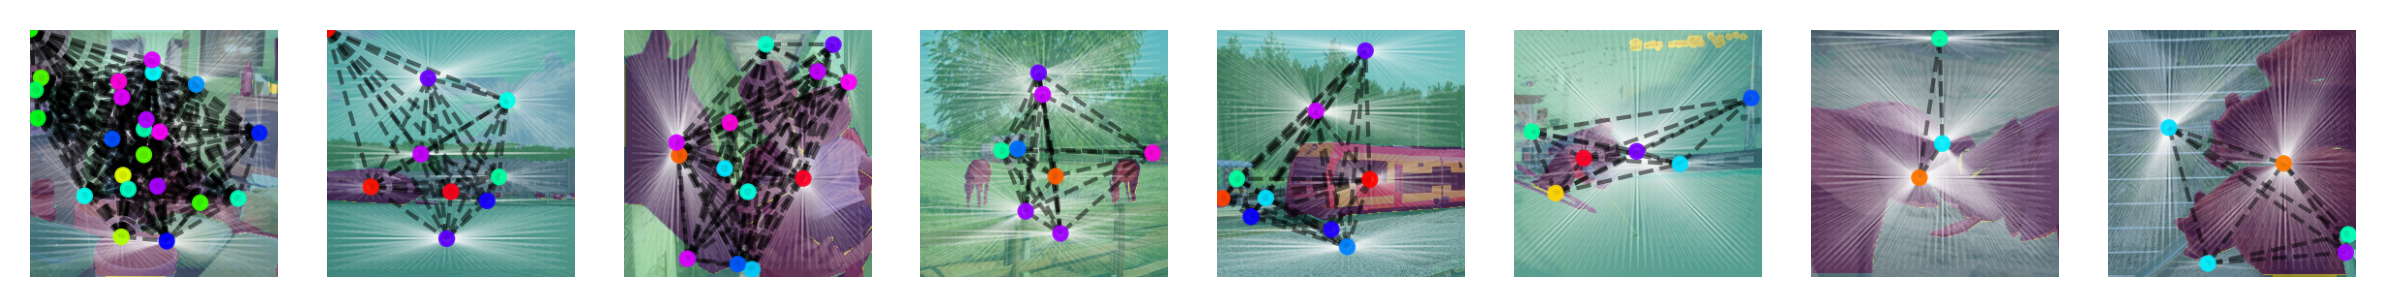

In [18]:
from hig_data.visualisation import logging_generate_sample_vis, visualise_het_graph_on_image_batch, plot_array_images
# logging_generate_sample_vis(graph_batch, resize_mask=True)
from training.encoders import StabilityVAEEncoder
vae = StabilityVAEEncoder()
img, decoded = visualise_het_graph_on_image_batch(graph_batch, vae=vae,)
print(img.shape)
plot_array_images(img)


In [ ]:
plot_array_images(decoded)

In [ ]:
from training.networks_edm2_hignn import Precond
precond = Precond(32, 3, gnn_metadata = data.metadata())

In [ ]:
import torch
images = torch.randn(1, 3, 32, 32)
rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
sigma = (rnd_normal).exp()

data = coco_graph[1]
out = precond(images, sigma, data)
out.shape